In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    class_likelihood_ratios,
    precision_recall_curve,
    det_curve,
    f1_score,
)

from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define variables and functions

In [2]:
# ---------- VARIABLES ----------
target          = 'DiagPeriodL90D'
phase           = 'test' # 'train' or 'test'
select_features = False
random_state    = 42

# Source: https://simple.wikipedia.org/wiki/List_of_ZIP_Code_prefixes
zip3_to_states = {
    103: 'NY', 104: 'NY', 105: 'NY', 109: 'NY', 111: 'NY',
    112: 'NY', 113: 'NY', 114: 'NY', 115: 'NY', 117: 'NY',
    118: 'NY', 119: 'NY', 122: 'NY', 124: 'NY', 125: 'NY',
    127: 'NY', 130: 'NY', 136: 'NY', 140: 'NY', 142: 'NY',
    148: 'NY', 157: 'PA', 170: 'PA', 171: 'PA', 180: 'PA',
    181: 'PA', 183: 'PA', 190: 'PA', 191: 'PA', 193: 'PA',
    196: 'PA', 208: 'MD', 209: 'MD', 212: 'MD', 232: 'VA',
    233: 'VA', 235: 'VA', 238: 'VA', 275: 'NC', 294: 'SC',
    295: 'SC', 300: 'GA', 302: 'GA', 303: 'GA', 307: 'GA',
    313: 'GA', 318: 'GA', 320: 'FL', 321: 'FL', 322: 'FL',
    324: 'FL', 326: 'FL', 327: 'FL', 330: 'FL', 331: 'FL',
    333: 'FL', 334: 'FL', 335: 'FL', 338: 'FL', 347: 'FL',
    349: 'FL', 359: 'AL', 365: 'AL', 370: 'TN', 371: 'TN',
    385: 'TN', 386: 'MS', 390: 'MS', 393: 'MS', 394: 'MS',
    402: 'KY', 403: 'KY', 420: 'KY', 435: 'OH', 442: 'OH',
    444: 'OH', 445: 'OH', 446: 'OH', 450: 'OH', 451: 'OH',
    452: 'OH', 454: 'OH', 460: 'IN', 471: 'IN', 473: 'IN',
    477: 'IN', 481: 'MI', 482: 'MI', 485: 'MI', 488: 'MI',
    490: 'MI', 491: 'MI', 532: 'WI', 553: 'MN', 559: 'MN',
    600: 'IL', 601: 'IL', 605: 'IL', 606: 'IL', 645: 'MO',
    647: 'MO', 652: 'MO', 660: 'KS', 662: 'KS', 666: 'KS',
    701: 'LA', 705: 'LA', 711: 'LA', 716: 'AR', 722: 'AR',
    729: 'AR', 731: 'OK', 741: 'OK', 750: 'TX', 754: 'TX',
    770: 'TX', 773: 'TX', 779: 'TX', 781: 'TX', 785: 'TX',
    786: 'TX', 800: 'CO', 801: 'CO', 809: 'CO', 816: 'CO',
    836: 'ID', 844: 'UT', 850: 'AZ', 852: 'AZ', 853: 'AZ',
    857: 'AZ', 870: 'NM', 871: 'NM', 875: 'NM', 883: 'NM',
    891: 'NV', 900: 'CA', 902: 'CA', 906: 'CA', 907: 'CA',
    908: 'CA', 911: 'CA', 913: 'CA', 916: 'CA', 917: 'CA',
    923: 'CA', 924: 'CA', 925: 'CA', 927: 'CA', 928: 'CA',
    930: 'CA', 935: 'CA', 937: 'CA', 945: 'CA', 949: 'CA',
    953: 'CA', 956: 'CA', 957: 'CA', 959: 'CA', 968: 'HI',
    970: 'OR', 971: 'OR', 972: 'OR', 973: 'OR', 974: 'OR',
    975: 'OR', 980: 'WA', 984: 'WA', 986: 'WA', 988: 'WA',
    991: 'WA'
}

idc9_to_idc10 = {
    '1749' : 'C50919',
    '1744' : 'C50419',
    '1741' : 'C50119',
    '1748' : 'C50819',
    '1743' : 'C50319',
    '1742' : 'C50219',
    '1746' : 'C50619',
    '19881': 'C7981' , # matastatic
    '1745' : 'C50519',
    '1759' : 'C50929',
}

# Source: https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html
states = [
    'AL','AK','AZ','AR','AS','CA','CO',
    'CT','DE','DC','FL','GA','GU','HI',
    'ID','IL','IN','IA','KS','KY','LA',
    'ME','MD','MA','MI','MN','MS','MO',
    'MT','NE','NV','NH','NJ','NM','NY',
    'NC','ND','MP','OH','OK','OR','PA',
    'PR','RI','SC','SD','TN','TX','TT',
    'UT','VT','VA','VI','WA','WV','WI',
    'WY'
]

states_to_ppc = {
    "AL": 223.32, "AK": 259.16, "AZ": 245.76,
    "AR": 212.61, "CA": 273.41, "CO": 288.57,
    "CT": 360.73, "DE": 257.70, "DC": 672.22,
    "FL": 264.63, "GA": 226.70, "HI": 300.92,
    "ID": 188.43, "IL": 287.09, "IN": 227.39,
    "IA": 215.30, "KS": 252.75, "KY": 241.20,
    "LA": 276.63, "ME": 325.49, "MD": 363.63,
    "MA": 435.38, "MI": 303.71, "MN": 307.13,
    "MS": 194.14, "MO": 276.54, "MT": 243.31,
    "NE": 255.83, "NV": 203.99, "NH": 313.64,
    "NJ": 317.42, "NM": 239.67, "NY": 369.76,
    "NC": 257.87, "ND": 240.53, "OH": 297.29,
    "OK": 209.56, "OR": 296.04, "PA": 328.25,
    "RI": 407.47, "SC": 234.15, "SD": 241.50,
    "TN": 263.69, "TX": 228.35, "UT": 226.04,
    "VT": 382.43, "VA": 268.53, "WA": 270.70,
    "WV": 261.02, "WI": 266.39, "WY": 196.37
}


# ---------- FUNCTIONS ----------

# Helper functions
def fill_na_states(row):
    if pd.isna(row['patient_state']):
        zip3 = row['patient_zip3']
        if zip3 in zip3_to_states:
            return zip3_to_states[zip3]
    return row['patient_state']
        
def add_age_group_column(df_):
    df = df_.copy()
    df['age_group'] = round(df['patient_age'], -1) + 10
    df['age_group'].value_counts()
    return df

def aggregate(df, group_col, input_col, method='mean'):
    """ Get the mean or mode of the input_col grouped by group_col
    Ex: - Get the mean of bmi by age_group
        - Get the mode of payer_type by age_group
    """
    result = {}
    for group in df[group_col].unique():
        if method == 'mean':
            result[group] = df[df[group_col] == group][input_col].mean()
        elif method == 'mode':
            result[group] = df[df[group_col] == group][input_col].mode()[0]
        elif method == 'median':
            result[group] = df[df[group_col] == group][input_col].median()
        else:
            print("Invalid method. Supported methods: ['mean', 'median', 'mode'].")
    return result
    
def get_zip3_multiple_states(df):
    return df.groupby('patient_zip3')\
        .filter(lambda x: x['patient_state'].nunique() > 1)['patient_zip3']\
        .unique()

def set_ppc(row):
    state = row['patient_state']
    return states_to_ppc[state] if state in states_to_ppc else np.mean(states_to_ppc)

def add_ppc_column(df_):
    df = df_.copy()
    df['ppc'] = df.apply(set_ppc, axis=1)
    return df

def combine_env_metrics(df_):
    df = df_.copy()
    df['env'] = df['Ozone'] * df['PM25'] * df['N02'] * df['patient_age'] * df['bmi']
    return df

def threshold(x, threshold_value=0):
    return np.array(x >= threshold_value, dtype=int)

# Encoding functions
def ordinal_encode(df_):
    df = df_.copy()
    cat_cols = df.select_dtypes(include='object')
    encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )
    for col in cat_cols:
        print("Ordinal encoding values for column", col)
        encoder.fit(df[[col]])
        df[col] = encoder.transform(df[[col]])
        
    return df

def onehot_encode(df_, columns):
    df = df_.copy()
    df = pd.get_dummies(df, columns=columns)
    print("OneHot encoding for columns", columns)
    return df

# Normalization functions
def minmax(df_):
    df = df_.copy()
    cols_to_normalize = [col for col in df.columns if col != target]
    scaler = MinMaxScaler()
    cols = df.columns
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    df.columns = cols
    return df

def standard(df_):
    df = df_.copy()
    cols_to_normalize = [col for col in df.columns if col != target]
    scaler = StandardScaler()
    cols = df.columns
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    df.columns = cols
    return df

# Data imputation functions
def impute_states(df_):
    df = df_.copy()
    print("Number of missing patient_states - Before:", df['patient_state'].isna().sum())
    df['patient_state'] = df.apply(fill_na_states, axis=1)
    print("Number of missing patient_states - After:", df['patient_state'].isna().sum())
    return df

def impute_zip3(df_):
    df = df_.copy()
    zip3_multiple_states = get_zip3_multiple_states(df)
    
    if len(zip3_multiple_states) > 0:
        print("Number of zip3 with multiple states - Before:", len(zip3_multiple_states))
        df['patient_state'] = df.apply(
            lambda row: zip3_to_states[row['patient_zip3']]\
                if row['patient_zip3'] in zip3_multiple_states\
                else row['patient_state'],
            axis=1
        )
        zip3_multiple_states = get_zip3_multiple_states(df)
        print("Number of zip3 with multiple states - After:", len(zip3_multiple_states))
    
    return df

def impute_payer_type(df_):
    df = df_.copy()
    
    if 'age_group' not in df.columns:
        df = add_age_group_column(df)
        
    mode_payer_type_by_age_groups = aggregate(df,'age_group','payer_type', method='mode')
    print("Number of missing payer type - Before:", df['payer_type'].isna().sum())
    df['payer_type'] = df['payer_type'].fillna(df['age_group'].map(mode_payer_type_by_age_groups))
    print("Number of missing payer type - After:", df['payer_type'].isna().sum())
    return df

def impute_race(df_):
    df = df_.copy()
    
    if 'age_group' not in df.columns:
        df = add_age_group_column(df)
        
    mode_race_by_age_groups = aggregate(df, 'age_group', 'patient_race', method='mode')
    print("Number of missing patient race - Before:", df['patient_race'].isna().sum())
    df['patient_race'] = df['patient_race'].fillna(df['age_group'].map(mode_race_by_age_groups))
    print("Number of missing patient race - After:", df['patient_race'].isna().sum())
    return df

def preprocess_breast_cancer_diagnosis_codes(df_):
    df = df_.copy()
    icd9_codes = df[~df['breast_cancer_diagnosis_code'].str.startswith('C')]['breast_cancer_diagnosis_code'].unique()
    print("Number of unique ICD-9 codes - Before:", len(icd9_codes))
    print("Unique ICD-9 codes:", icd9_codes)

    # Check if all icd-9 codes have a corresponding icd-10 code
    for code in icd9_codes:
        if code not in idc9_to_idc10:
            print(code)

    # Map ICD-9 codes to ICD-10 codes
    df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].apply(
        lambda code: idc9_to_idc10[code] if code in idc9_to_idc10 else code
    )

    icd9_codes = df[~df['breast_cancer_diagnosis_code'].str.startswith('C')]['breast_cancer_diagnosis_code'].unique()
    print("Number of unique ICD-9 codes - After:", len(icd9_codes))
    print("Unique breast_cancer_diagnosis_code:", df['breast_cancer_diagnosis_code'].unique())
    
    return df


def impute_general(df_):
    df = df_.copy()
    
    num_cols = df.select_dtypes(include=['float', 'int']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    # Impute categorical columns using most frequent values
    for col in cat_cols:
        if (df[col].isna().sum() > 0) and (col != target):
            print("Imputing values using mode for column", col)
            mode = df[col].mode()[0]
            df[col].fillna(mode, inplace=True)

    # Impute numerical columns using median values
    for col in num_cols:
        if (df[col].isna().sum() > 0) and (col != target):
            print("Imputing values using median for column", col)
            median = df[col].median()
            df[col].fillna(median, inplace=True)
    
    return df


def impute_bmi(df_):
    df = df_.copy()
    
    if 'age_group' not in df.columns:
        df = add_age_group_column(df)
    
    mean_bmi_by_age_groups = aggregate(df,'age_group','bmi', method='mean')
    print("Number of missing bmi - Before:", df['bmi'].isna().sum())
    df['bmi'] = df['bmi'].fillna(df['age_group'].map(mean_bmi_by_age_groups))
    print("Number of missing bmi - After:", df['bmi'].isna().sum())
    return df
    

def impute(df):
#     df = impute_states(df)
#     df = impute_zip3(df)
#     df = impute_payer_type(df)
#     df = impute_race(df)
#     df = impute_bmi(df)
    #df = preprocess_breast_cancer_diagnosis_codes(df)
    #df = add_ppc_column(df)
    df = impute_general(df)

    return df

# Process functions
def process(df_):
    df = df_.copy()
    
    # Remove patient_id
    if 'patient_id' in df.columns:
        df = df.drop(columns=['patient_id'])
    
    # Encode categorical values
    df = ordinal_encode(df)
        
    # Convert to type float
    df = df.astype('float64')
    
    # Normalize values to the same range
    #df = minmax(df)
    df = standard(df)
    
    # Combine environmental features as a single feature
    if 'env' not in df.columns:
        df = combine_env_metrics(df)
    
    return df
    
def get_datasets(df_):
    train = df[df[target] != 2]
    test  = df[df[target] == 2].drop(columns=[target])
    print(f"Train shape: {train.shape}, test shape: {test.shape}")

    X = train.drop(columns=[target], axis=1)
    y = train[target]
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    return X, y, test

# Visualization functions
def plot_roc_curve(y_true, y_pred):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(
        fpr, tpr,
        color='darkorange',
        lw=2,
        label='ROC curve (area = %0.2f)' % roc_auc
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, threshold, filename=None):
    y_pred_binary = (y_pred > threshold).astype(float)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        square=True, cbar=False,
        xticklabels=["Predicted 0", "Predicted 1"],
        yticklabels=["Actual 0", "Actual 1"]
    )
    plt.title(f"threshold={threshold}")
    if filename:
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/{filename}', format='jpeg')
    plt.show()
    
def plot_catboost_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    fig = plt.figure(figsize=(6, 3))
    plt.barh(
        range(len(sorted_idx)),
        feature_importance[sorted_idx],
        align='center'
    )
    plt.yticks(
        range(len(sorted_idx)),
        np.array(columns)[sorted_idx]
    )
    plt.title('Feature Importance')
    
# Clean data functions
def clean_bmi(df_):
    df = df_.copy()
    n_large_bmi = df[df['bmi'] > 45].shape[0]
    if n_large_bmi > 0:
        print("Number of rows that have bmi > 45 - Before:", n_large_bmi)
        indices_to_drop = train[train['bmi'] > 45].index
        df.drop(indices_to_drop, inplace=True)
        print("Number of rows that have bmi > 45 - After:" , df[df['bmi'] > 45].shape[0])
    return df

def clean(df):
    df = clean_bmi(df)
    return df

# 2. Preprocess data

In [3]:
train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/training.csv')
test  = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/test.csv')

print(f"train shape: {train.shape}, test shape: {test.shape}")

train shape: (12906, 83), test shape: (5792, 82)


## 2.1. Clean data

In [4]:
# print("--- Cleaning train dataset ---")
# train = clean(train)
# print("")
# print("--- Cleaning test dataset ---")
# test  = clean(test)

# print(train.shape, test.shape)

## 2.2. Impute missing values

In [5]:
print("--- Imputing missing values for train dataset ---")
cleaned_train = impute(train)
print("")
print("--- Imputing missing values for test dataset ---")
cleaned_test = impute(test)

print(cleaned_train.shape, cleaned_test.shape)

--- Imputing missing values for train dataset ---
Imputing values using mode for column patient_race
Imputing values using mode for column payer_type
Imputing values using mode for column patient_state
Imputing values using mode for column metastatic_first_novel_treatment
Imputing values using mode for column metastatic_first_novel_treatment_type
Imputing values using mode for column Region
Imputing values using mode for column Division
Imputing values using median for column bmi
Imputing values using median for column population
Imputing values using median for column density
Imputing values using median for column age_median
Imputing values using median for column age_under_10
Imputing values using median for column age_10_to_19
Imputing values using median for column age_20s
Imputing values using median for column age_30s
Imputing values using median for column age_40s
Imputing values using median for column age_50s
Imputing values using median for column age_60s
Imputing values usi

In [6]:
# Combine train and test for preprocessing and feature selection
cleaned_test[target] = 2
df = process(pd.concat([cleaned_train, cleaned_test]))
X, y, test = get_datasets(df)
X.head()

Ordinal encoding values for column patient_race
Ordinal encoding values for column payer_type
Ordinal encoding values for column patient_state
Ordinal encoding values for column patient_gender
Ordinal encoding values for column breast_cancer_diagnosis_code
Ordinal encoding values for column breast_cancer_diagnosis_desc
Ordinal encoding values for column metastatic_cancer_diagnosis_code
Ordinal encoding values for column metastatic_first_novel_treatment
Ordinal encoding values for column metastatic_first_novel_treatment_type
Ordinal encoding values for column Region
Ordinal encoding values for column Division
Train shape: (12906, 83), test shape: (5792, 82)
X shape: (12906, 82), y shape: (12906,)


,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,env
0,0.490282,0.517679,-1.198907,1.275765,1.870122,0.0,-0.071733,1.047839,0.884682,2.125689,0.029265,0.0,1.187545,0.434208,0.783995,-0.125882,-2.449348,3.257675,1.357511,1.302983,0.496166,-0.361692,-1.155573,-1.966392,-1.703090,-1.536247,-0.144507,0.144463,-1.489967,-0.393704,1.664255,-0.899698,3.232564,0.060643,-1.026707,-0.088165,1.112369,1.136652,0.832480,1.636710,0.782587,0.674614,1.132499,0.036576,-1.338540,-1.021505,-1.203694,-1.452771,-1.528344,0.234815,-0.291061,-0.159533,1.268208,4.155110,0.192717,-0.618854,-1.755640,-1.508772,-1.702321,-0.820235,-0.009906,1.309251,0.069217,-0.609728,-1.433052,0.131856,-0.045766,0.223524,0.356866,3.452910,0.603008,2.855683,-0.138075,1.760113,1.186922,-0.028607,0.622718,-1.161603,3.517305,0.781764,0.437295,-0.161306
1,0.490282,-0.739244,-1.198907,1.290289,0.210361,0.0,0.023336,-0.102058,-1.098444,-0.689209,0.029265,0.0,1.187545,0.434208,1.339675,0.250330,-0.576255,0.504107,0.217437,0.288486,0.240903,1.014705,0.378280,-0.927000,-0.797548,-0.402766,-0.122339,0.122294,0.338641,-1.398370,0.190460,-0.764422,1.872632,1.459006,1.382396,-0.651539,-0.734633,-0.853491,-1.216156,-1.247827,-1.472953,-1.407462,-1.101555,-0.113300,1.243575,1.454760,1.524713,0.590576,-0.329612,0.857551,1.353429,1.803197,0.710970,0.435738,-0.958651,0.174574,0.733321,0.009102,0.394587,0.983815,0.611039,-0.435657,0.595820,-0.600999,-0.880003,-0.710086,2.306839,-0.127558,0.280606,0.965302,0.976481,1.158663,-1.198154,-0.637626,0.760266,0.523442,-0.376632,-0.967606,0.704990,0.674177,0.694745,0.001621
2,0.490282,-0.739244,1.445138,0.680260,-1.223068,0.0,3.065571,-0.767788,-0.371298,-0.689209,0.029265,0.0,0.334010,1.518499,0.101260,-0.317435,-0.648959,1.269517,0.795097,-0.220755,0.295209,0.635719,-0.412464,-0.469561,-0.512879,-0.961305,0.015860,-0.015908,1.075201,-0.176861,-0.818702,-0.726505,0.262735,0.586158,0.570881,-0.543738,-0.908088,-0.814818,-0.691191,-0.980776,-0.748306,0.190632,-0.402032,0.484922,1.594952,0.229782,0.640788,0.482049,0.471631,0.053594,-0.398242,0.006519,-0.406649,-0.232538,-0.077457,0.700033,0.076212,-0.350672,-0.138147,-1.305427,0.812001,-0.716959,0.155278,0.558731,0.333533,-0.176192,-0.267405,-0.176259,0.007763,-0.293678,0.078945,0.061547,-0.576341,-0.723586,-0.221737,0.679431,1.546754,0.108055,0.084306,0.118121,-0.206425,0.007707
3,0.490282,-0.739244,-1.198907,1.283027,-1.072181,0.0,-0.071733,-0.525704,-1.627278,-0.689209,0.029265,0.0,1.187545,0.434208,0.882168,0.114409,0.581593,-0.699300,-0.417554,-0.218828,-0.167574,0.467577,0.860477,-0.137876,0.253528,0.612331,-0.620731,0.620698,0.654147,-0.521532,-0.326599,-0.782384,-0.460137,0.404169,2.244049,0.114130,-0.931471,-1.118680,-1.193267,-1.478667,-1.827502,-2.223136,-2.221135,-1.072531

## 2.3. Select features

### 2.3.1. Using `SelectFromModel` and `XGBClassifier`

In [7]:
if select_features:
    # Fit a XGB classifier to get feature importances
    params = {
        "n_estimators": 417,
        "learning_rate": 0.005060571016010517,
        "max_depth": 9,
        "subsample": 0.8368633456010389,
        "colsample_bytree": 0.759602448382082,
        "gamma": 0.04182791414542354
    }

    xgb = XGBClassifier(**params)
    xgb.fit(X, y)

    # Use SelectFromModel to select features based on importance
    selector = SelectFromModel(xgb, prefit=True)

    # Get selected features and their importances
    selected_mask        = selector.get_support()
    selected_features    = selector.get_feature_names_out(X.columns)
    selected_importances = xgb.feature_importances_[selected_mask]

    print("Selected features", selected_features)
    print("Selected importances", selected_importances)

    # Sort the selected features by their importance
    sorted_indices     = np.argsort(selected_importances)[::-1]
    sorted_features    = selected_features[sorted_indices]
    sorted_importances = selected_importances[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances using XGBClassifier")
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    xgb_selected_features = selected_features

### 2.3.2. Using `SelectFromModel` and `ExtraTreesClassifier`

In [8]:
if select_features:
    trees = ExtraTreesClassifier()
    trees.fit(X,y)

    # Use SelectFromModel to select features based on importance
    selector = SelectFromModel(trees, prefit=True)

    # Get selected features and their importances
    selected_mask        = selector.get_support()
    selected_features    = selector.get_feature_names_out(X.columns)
    selected_importances = trees.feature_importances_[selected_mask]

    print("Selected features", selected_features)
    print("Selected importances", selected_importances)
    print(cb.feature_importances_)

    # Sort the selected features by their importance
    sorted_indices     = np.argsort(selected_importances)[::-1]
    sorted_features    = selected_features[sorted_indices]
    sorted_importances = selected_importances[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances using ExtraTreesClassifier")
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    trees_selected_features = selected_features

In [9]:
if select_features:
    suggested_features = list(set(xgb_selected_features).union(set(trees_selected_features)))
    print(suggested_features)

### 2.3.3. Using `RFE` and `XGBClassifier` 

In [10]:
if select_features:
    # Initialize the base model
    params = {
        "n_estimators": 417,
        "learning_rate": 0.005060571016010517,
        "max_depth": 9,
        "subsample": 0.8368633456010389,
        "colsample_bytree": 0.759602448382082,
        "gamma": 0.04182791414542354
    }

    xgb = XGBClassifier(**params)

    # Initialize RFE with the base model and the number of features to select
    rfe = RFE(estimator=xgb, n_features_to_select=5)

    # Fit RFE
    rfe.fit(X, y)

    tmp_df = pd.DataFrame({
        'features': X.columns,
        'ranking' : rfe.ranking_,
    })
    tmp_df = tmp_df.sort_values('ranking')

    ranking = tmp_df['ranking'][::-1]
    feature_names = tmp_df['features'][::-1]

    # Plotting
    plt.figure(figsize=(10, 20))
    plt.title("Feature Importances")
    plt.barh(range(len(ranking)), ranking, color="blue", align="center")
    plt.yticks(range(len(ranking)), feature_names)
    plt.xlabel("Feature Importance Rank")
    plt.ylabel("Feature")
    plt.show()

    # Note: Features with rank 1 are selected by RFE. Lower rank means higher importance.

In [11]:
features = [    
    'breast_cancer_diagnosis_code',
    'metastatic_cancer_diagnosis_code',
    'patient_race',
    'bmi',
    'payer_type',
    'patient_age',
]
X = X[features]
print(X.shape)
X.head()

(12906, 6)


,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,patient_race,bmi,payer_type,patient_age
0,1.047839,2.125689,0.490282,-0.071733,0.517679,1.870122
1,-0.102058,-0.689209,0.490282,0.023336,-0.739244,0.210361
2,-0.767788,-0.689209,0.490282,3.065571,-0.739244,-1.223068
3,-0.525704,-0.689209,0.490282,-0.071733,-0.739244,-1.072181
4,-1.433518,-0.689209,0.490282,-0.071733,-0.739244,-0.317745


# 3. Model

## 3.1. Get train and validation sets for training

In [12]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=random_state
)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(11615, 6) (11615,)
(1291, 6) (1291,)


## 3.2. Select best hyperparams

In [13]:
# Find best hyperparams for CatBoost
def objective(trial):
    params = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth'       : trial.suggest_int('max_depth', 3, 6),
        'subsample'       : trial.suggest_float('subsample', 0.1, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.6),
        'gamma'           : trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state'    : random_state,
    }

    model = XGBClassifier(**params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    return auc

if phase == 'train':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=200)
    best_params = study.best_params
    print(best_params)

In [14]:
if phase == 'train':
    # Plot params importances
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [15]:
if phase == 'train':
    fig = optuna.visualization.plot_rank(study, params=["learning_rate", "max_depth"])
    fig.show()

## 3.3. Train ML Models

In [16]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

# If phase == 'test', use hard-coded params
if phase == 'test':
    best_params = {
        'n_estimators'    : 80,
        'learning_rate'   : 0.1073,
        'max_depth'       : 5, 
        'subsample'       : 0.5411,
        'colsample_bytree': 0.5792,
        'gamma'           : 0.0005
    }

# If phase = 'train', use optuna best params
print("Best params", best_params)

auc_scores = []
test_preds = []
val_preds  = []
fold       = 1

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    val_preds_fold = model.predict_proba(X_val)[:, 1]
    test_preds_fold = model.predict_proba(test[features])[:, 1]
    test_preds.append(test_preds_fold)
    
    auc_score = roc_auc_score(y_val, val_preds_fold)
    auc_scores.append(auc_score)
    print(f"Fold {fold} XGBoost AUC Score: {auc_score:.4f}")
    fold += 1

print("-"*20)
print(f"Mean CatBoost AUC score: {np.mean(auc_scores)}")

Best params {'n_estimators': 80, 'learning_rate': 0.1073, 'max_depth': 5, 'subsample': 0.5411, 'colsample_bytree': 0.5792, 'gamma': 0.0005}
Fold 1 XGBoost AUC Score: 0.8041
Fold 2 XGBoost AUC Score: 0.7998
Fold 3 XGBoost AUC Score: 0.7936
Fold 4 XGBoost AUC Score: 0.7990
Fold 5 XGBoost AUC Score: 0.8048
--------------------
Mean CatBoost AUC score: 0.8002774320953471


<Axes: >

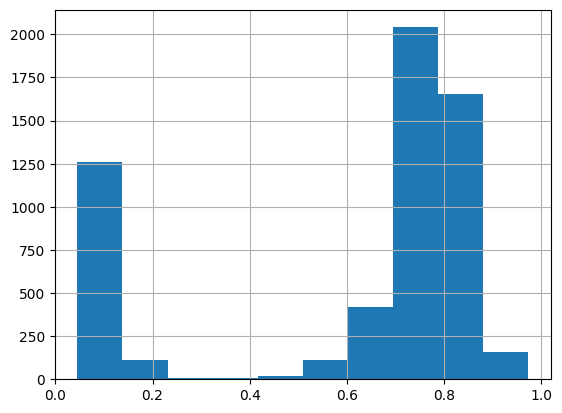

In [17]:
mean_test_preds = np.mean(test_preds, axis=0)
pd.Series(mean_test_preds).hist()

# 4. Submit

In [18]:
submission = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv')
submission[target] = mean_test_preds
submission.to_csv('submission.csv', index=False)